In [2]:

import torch
import torchaudio
import numpy as np
import os
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
from IPython.lib.display import Audio

#from decaynet_toolbox import DecaynetToolbox
from toolbox.DecayFitNetToolbox import DecayFitNetToolbox
from toolbox.utils import plot_waveform, plot_fft

In [3]:
## Parameters
audio_path = '/m/cs/work/falconr1/datasets/MusicSamples'
audio_path = '/Volumes/scratch/work/falconr1/datasets/MusicSamples'
#rir_fname = 'Single_503_1_RIR.wav'  # Single slope clean
#rir_fname = 'Single_502_1_RIR.wav'
#rir_fname = 'Single_EE_lobby_1_RIR.wav'  # Long tail

audio_path = '/Volumes/scratch/elec/t40527-hybridacoustics/datasets/summer830/raw_rirs'
#rir_fname = '0825_1_raw_rirs.wav'
#rir_fname = '0825_4_raw_rirs.wav'
#rir_fname = '0001_4_raw_rirs.wav'  # Huge
rir_fname = '0001_1_raw_rirs.wav'  # First measurement


#precomputed_path = '/Volumes/scratch/elec/t40527-hybridacoustics/datasets/decayfitting/summer830'
precomputed_path = '/Volumes/scratch/elec/t40527-hybridacoustics/datasets/decayfit_toolbox/summer830'
precomputed_fname = 'edcs.mat'

torch.Size([32, 120000])
The impulse has 32 channels (before selecting the first one).
The impulse has 120000 timesteps at 48000 sampling rate = 2.5 seconds.


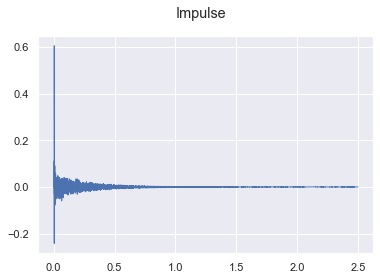

In [5]:
# Load some impulse
impulse, fs = torchaudio.load(os.path.join(audio_path, rir_fname))
channels = impulse.shape[0]
if impulse.shape[0] > 1 and len(impulse.shape) > 1:
    print(impulse.shape)
    impulse = impulse[0:1,:]
    
print(f'The impulse has {channels} channels (before selecting the first one).')
print(f'The impulse has {impulse.shape[-1]} timesteps at {fs} sampling rate = {impulse.shape[-1] / fs} seconds.')

plot_waveform(impulse, fs, title='Impulse')
Audio(impulse, rate=fs, autoplay=False)

In [6]:
# Load a precomputed EDC
f_edcs = h5py.File(os.path.join(precomputed_path, precomputed_fname), 'r')
precomputed_edcs = torch.from_numpy(np.array(f_edcs.get('summer830edcs/edcs'))).float().view(-1, 2400)
for rir_idx in tqdm(range(precomputed_edcs.shape[0])):
    this_edc = precomputed_edcs[rir_idx, :]
    this_edc_nozeros = this_edc[this_edc > 0]
    this_edc[this_edc == 0] = this_edc_nozeros[-1]
    this_edc = this_edc.view(1, -1)
    precomputed_edcs[rir_idx, :] = this_edc

  0%|          | 0/19920 [00:00<?, ?it/s]

In [12]:
# Prepare the model
decayfitnet = DecayFitNetToolbox(sample_rate=fs, normalization=True)
print(decayfitnet)

# Generate time axis
time_axis = (torch.linspace(0, impulse.shape[1] - 1, impulse.shape[1]) / fs)

new_fs = (decayfitnet.output_size * fs) / impulse.shape[-1] 
print(f'New fs for plotting = {new_fs}')
# Process
prediction = decayfitnet.estimate_parameters(impulse)
generated_edc = decayfitnet.generate_EDCs(prediction[0],
                                          prediction[1],
                                          prediction[2],
                                          time_axis=time_axis)
print('')
print('Prediction:')
print(f'\t T_vals = {prediction[0]} \n')
print(f'\t A_vals = {prediction[1]} \n')
print(f'\t Noise_vals = {prediction[2]} \n')
#print(f'\t scores_slopes = {prediction[3]} \n')
#_, n_slopes = torch.max(prediction[3], dim=-1)
#print(f'\t pred_slopes = {n_slopes.unsqueeze(-1) + 1} \n')

DecayFitNetToolbox 0.0.3  
Input fs = 48000 
Output_size = 2400 
Normalization = True 
Filter freqs = [125, 250, 500, 1000, 2000, 4000] 

New fs for plotting = 960.0

Prediction:
	 T_vals = tensor([[2.9705, 1.0000, 1.0000],
        [1.5950, 2.1934, 1.0000],
        [1.6096, 2.1863, 1.0000],
        [2.0962, 1.0000, 1.0000],
        [1.5358, 2.0607, 1.0000],
        [1.2025, 1.7114, 1.0000]]) 

	 A_vals = tensor([[0.9504, 0.0000, 0.0000],
        [0.3483, 0.7325, 0.0000],
        [0.7015, 0.3322, 0.0000],
        [0.8459, 0.0000, 0.0000],
        [0.5945, 0.4149, 0.0000],
        [0.8923, 0.1648, 0.0000]]) 

	 Noise_vals = tensor([[1.3395e-08],
        [2.0008e-09],
        [2.9463e-10],
        [5.9999e-10],
        [2.7790e-10],
        [1.1580e-10]]) 



torch.Size([6, 2400])


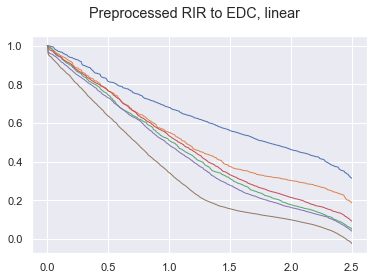

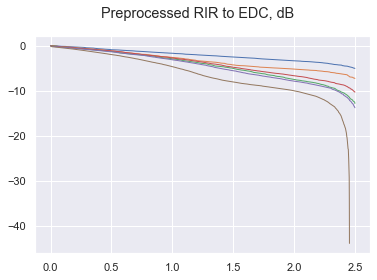

In [14]:
# Validate extracted EDCs
# This is the input to the net
edcs = decayfitnet.preprocess(impulse)
print(edcs.shape)
plot_waveform(edcs.unsqueeze(0), sample_rate=new_fs, title='Preprocessed RIR to EDC, linear')
plot_waveform(10 * torch.log10(edcs.unsqueeze(0)), sample_rate=new_fs, title='Preprocessed RIR to EDC, dB')

torch.Size([6, 1, 114000])


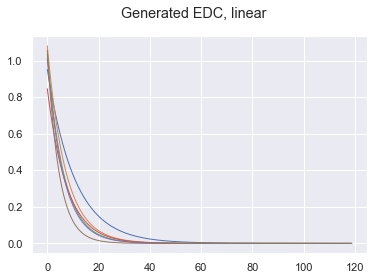

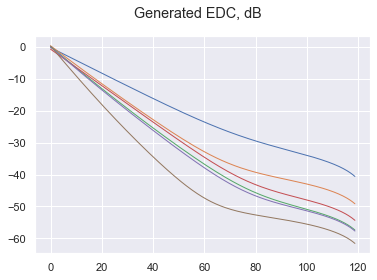

In [15]:
# Plot
print(generated_edc.shape)
#plot_waveform(generated_edc.unsqueeze(0), sample_rate=new_fs, title='Generated EDC, linear')
#plot_waveform(10 * torch.log10(generated_edc.unsqueeze(0)), sample_rate=new_fs, title='Generated EDC, dB')
plot_waveform(generated_edc.permute([1,0,2]), sample_rate=new_fs, title='Generated EDC, linear')
plot_waveform(10 * torch.log10(generated_edc.permute([1,0,2])), sample_rate=new_fs, title='Generated EDC, dB')

torch.Size([2400])


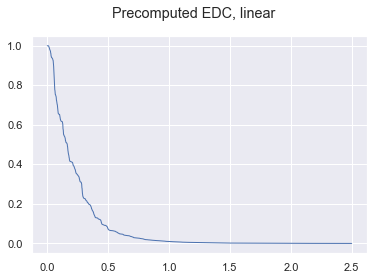

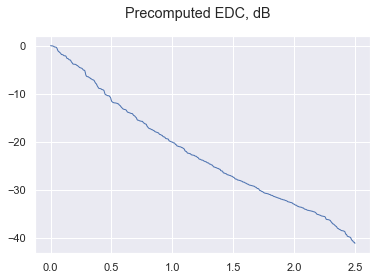

In [16]:
# Plot Precomputed
print(precomputed_edcs[0,:].shape)
plot_waveform(precomputed_edcs[0,:].unsqueeze(0), sample_rate=new_fs, title='Precomputed EDC, linear')
plot_waveform(10 * torch.log10(precomputed_edcs[0,:].unsqueeze(0)), sample_rate=new_fs, title='Precomputed EDC, dB')

In [ ]:
# Save input transform to mat file for convienece
